##  Data generation

Given covariance function $cov(k(x, y))$, need generate random field with given covariance

In [1]:
%matplotlib inline
import numpy as np
import scipy.sparse as scsp
import matplotlib.pyplot as plt
import scipy.linalg as sclin
import scipy.sparse.linalg as scspl

/home/alex/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
def cov_func(points, alpha=1, beta=1):
    '''
    Function generated covariance matrix for given points 
    and parameters alpha and beta
    '''
    n = points.shape[0]
    A = np.zeros((n, n))
    for i in xrange(n):
        for j in xrange(n):
            norm = np.linalg.norm(points[i] - points[j])
            A[i, j] = np.exp(-norm**alpha / beta) 
    return A

In [3]:
def col_covmatrix(points, alpha=1, beta=1):
    '''
    Function generates first column of the 
    covariance matrix to store it efficiently
    '''
    n = points.shape[0]
    A = np.zeros((n,))
    for i in xrange(n):
        norm = np.sqrt((points[i, 0] - points[0, 0])**2 + (points[i, 1] - points[0, 1])**2)
        A[i, ] = np.exp(-norm**alpha / beta)
    return A

In [4]:
def symtoeplitz2circulant(A):
    '''
    Function converts the first column of 
    symmetrix toeplitz matrix to the first
    column of circulant matrix
    '''
    n = A.shape[0]
    col = np.zeros((2*(n-1), ))
    col[:n] = A[:n]
    col[n:] = A[-2:-n:-1]
    return col

In [5]:
def coltoeplitz2colcircuant(A):
    '''
    Function converts first column of 
    BTTB to first column of BCCB
    '''
    n = A.shape[0]
    m = int(round(np.sqrt(n)))
    num_blocks = n / m
    B = np.zeros(((2*(m-1))**2, ))
    for i in xrange(num_blocks):
        B[i*(2*(m-1)):(i+1)*(2*(m-1))] = symtoeplitz2circulant(A[i*num_blocks:(i+1)*num_blocks])
    for j in xrange(num_blocks-2):
        B[2*(m-1)*(num_blocks+j):2*(m-1)*(num_blocks+j+1)] = B[2*(m-1)*(num_blocks-2-j):2*(m-1)*(num_blocks-1-j)]
    return B

## Create matrix and solve PDE

In [13]:
def create_matrix(covar, rhs):
    '''
    Function create matrix and rhs to solve discretized 
    general Poisson equation in the form div(k grad(u)) = rhs
    '''
    n = covar.shape[0]
    A = scsp.lil_matrix((n**2, n**2))
    b = np.zeros((n*n, ))
    inner_points2ind = {}
    bound_points2ind = {}
    k = 0
    for i in xrange(n):
        for j in xrange(n):
            if i == 0 or j == 0 or i == n-1 or j == n-1:
                bound_points2ind[(i, j)] = k
                k += 1
            else:
                inner_points2ind[(i, j)] = k
                k += 1
    ind2inner_points = {inner_points2ind[key]: key for key in inner_points2ind}
    ind2bound_points = {bound_points2ind[key]: key for key in bound_points2ind}
    for k in ind2inner_points:
        i, j = ind2inner_points[k]
        b[k] = rhs[i, j]
        A[k, k] = -(covar[i, j+1] + covar[i-1, j] + covar[i+1, j] + covar[i, j-1] + 4*covar[i, j]) / 2
        if j + 1 != n -1:
            l1 = inner_points2ind[(i, j+1)]
        else:
            l1 = bound_points2ind[(i, j+1)]
        A[k, l1] = (covar[i, j+1] + covar[i, j]) / 2
        
        if j - 1 != 0:
            l2 = inner_points2ind[(i, j-1)]
        else:
            l2 = bound_points2ind[(i, j-1)]
        A[k, l2] = (covar[i, j-1] + covar[i, j]) / 2
        
        if i + 1 != n-1:
            k1 = inner_points2ind[(i+1, j)]
        else:
            k1 = bound_points2ind[(i+1, j)]
        A[k, k1] = (covar[i+1, j] + covar[i, j]) / 2
        
        if i-1 != 0:
            k2 = inner_points2ind[(i-1, j)]
        else:
            k2 = bound_points2ind[(i-1, j)]
        A[k, k2] = (covar[i-1, j] + covar[i, j]) / 2
    
    for k in ind2bound_points:
        A[k ,k] = 1
    A = A * (n-1)**2
    return A.tocsr(), b, ind2inner_points, ind2bound_points

In [28]:
def solve(random_field, rhs, disp=False):
    '''
    Function solves the PDE div(k grad(u)) = rhs for 
    given k and rhs
    '''
    n = rhs.shape[0]
    A, b, ind2inner, ind2bound = create_matrix(random_field, rhs)
    x = scspl.spsolve(A, b)
    u = np.zeros((n, n))
    for k in ind2inner:
        i, j = ind2inner[k]
        u[i, j] = x[k]
    for k in ind2bound:
        i, j = ind2bound[k]
        u[i, j] = x[k]
    if disp:
        plt.figure()
        plt.imshow(u, cmap="jet", interpolation="bicubic")
        plt.colorbar()
        plt.figure()
        plt.imshow(random_field, cmap="jet", interpolation="bicubic")
        plt.colorbar()
    return u

In [8]:
def create_random_field(col_A, n):
    '''
    Function creates random field for given first
    column of the covariance matrix
    '''
    col_circ = coltoeplitz2colcircuant(col_A)
    key_col = col_circ
    key_mat = np.reshape(key_col, (2*(n-1), 2*(n-1)))
    fft_key_mat = np.fft.fft2(key_mat)
    Lam = np.sqrt(fft_key_mat)
    x = np.random.randn(2*(n-1), 2*(n-1)) + 1j*np.random.randn(2*(n-1), 2*(n-1))
    rand_field = np.fft.ifft2(Lam * (np.fft.fft2(x)))[:n, :n]
    random_field = rand_field.imag
    return random_field 

In [9]:
def integrate(u):
    n = u.shape[0]
    h = 1.0 / n
    val = h**2 * np.sum(u[40:80, 40:80])
    return val

## Demo script

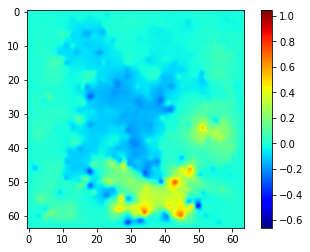

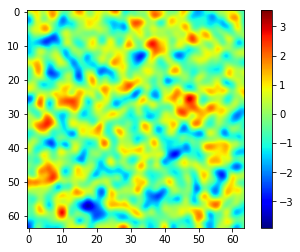

In [29]:
n = 64
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
xv, yv = np.meshgrid(x, y)
p = np.hstack((xv.reshape((n*n, 1)), yv.reshape((n*n, 1))))
size = 1
X = np.zeros((size, 1, n, n))
y = np.zeros(size)
for t in xrange(size):
    col_A = col_covmatrix(p, 2, 1e-3)
    rhs = np.ones((n, n))
    random_field = create_random_field(col_A, n)
    u = solve(random_field, rhs, True)
    val = integrate(u)
    X[t, 0, :, :] = u
    y[t] = val
    
X = X.astype(np.float32)
y = y.astype(np.float32)
nidx = X.shape[0]
idx = range(nidx)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [11]:
y = y.reshape((-1, 1))
print y.shape

(1, 1)


## Use DLNN to predict $y$ base on random field

In [12]:
import tensorflow as tf
